# COVID-19 

In this notebook we will go through the developments around the COVID-19 virus infections. First we look at the developments worldwide and finally EU only.

The dataset which I use in this project is provided by the [`European Centre for Disease Prevention and Control (ECDC)`](https://www.ecdc.europa.eu/en/geographical-distribution-2019-ncov-cases)

* Author: Erfan Nariman
* Date: 10-03-2020
* GitHub: [erfannariman](github.com/ErfPy)

---

In [1]:
import pandas as pd
import os
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from requests import HTTPError

plt.style.use('seaborn')
pd.set_option('display.max_columns', None)

---

### data import

In [2]:
def import_data():
    """
    this scripts import the COVID-19 geographic distribution data from ECDC
    it also catches errors if you try to download data which is not uploaded yet
    in that case it will read the data from the day before
    """
    
    try:
        date = dt.datetime.today().strftime('%Y-%m-%d')
        df = pd.read_excel(f'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{date}.xlsx')
    except HTTPError as e:
        print('File on ECDC not found, reading in data from day before')
        date = (dt.datetime.today() - dt.timedelta(days=1)).strftime('%Y-%m-%d')
        df = pd.read_excel(f'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{date}.xlsx')
        
    return df
        
df = import_data()
df.head()

,DateRep,Day,Month,Year,Cases,Deaths,Countries and territories,GeoId
0,2020-03-20,20,3,2020,0,0,Afghanistan,AF
1,2020-03-19,19,3,2020,0,0,Afghanistan,AF
2,2020-03-18,18,3,2020,1,0,Afghanistan,AF
3,2020-03-17,17,3,2020,5,0,Afghanistan,AF
4,2020-03-16,16,3,2020,6,0,Afghanistan,AF


---

# Worldwide
Minus China, to get rid of the extreme values for our model later on.
China is analyzed further on in this notebook

### data cleaning

In [3]:
# clean up column names
df.columns = df.columns.str.replace('DateRep', 'Date').str.replace('Countries and territories', 'Country')

# convert Date column to datetime type
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

# we filter out China to get rid of the extreme values
china = df.query('Country.eq("China")').copy()
df = df.query('Country.ne("China")').copy()

# replace name to Japan
df['Country'] = df['Country'].str.replace('Cases on an international conveyance Japan', 'Japan')

# print first 5 rows of dataframe
df.head()

,Date,Day,Month,Year,Cases,Deaths,Country,GeoId
0,2020-03-20,20,3,2020,0,0,Afghanistan,AF
1,2020-03-19,19,3,2020,0,0,Afghanistan,AF
2,2020-03-18,18,3,2020,1,0,Afghanistan,AF
3,2020-03-17,17,3,2020,5,0,Afghanistan,AF
4,2020-03-16,16,3,2020,6,0,Afghanistan,AF


### exploratory data analysis (EDA)

In [4]:
# range of data in days
df['Date'].max() - df['Date'].min()

Timedelta('80 days 00:00:00')

In [5]:
# checking for missing days by resampling and checking for NaN
df.set_index('Date').resample('D').mean().isna().sum()

Day       0
Month     0
Year      0
Cases     0
Deaths    0
dtype: int64

### which countries had highest new confirmed cases on a day

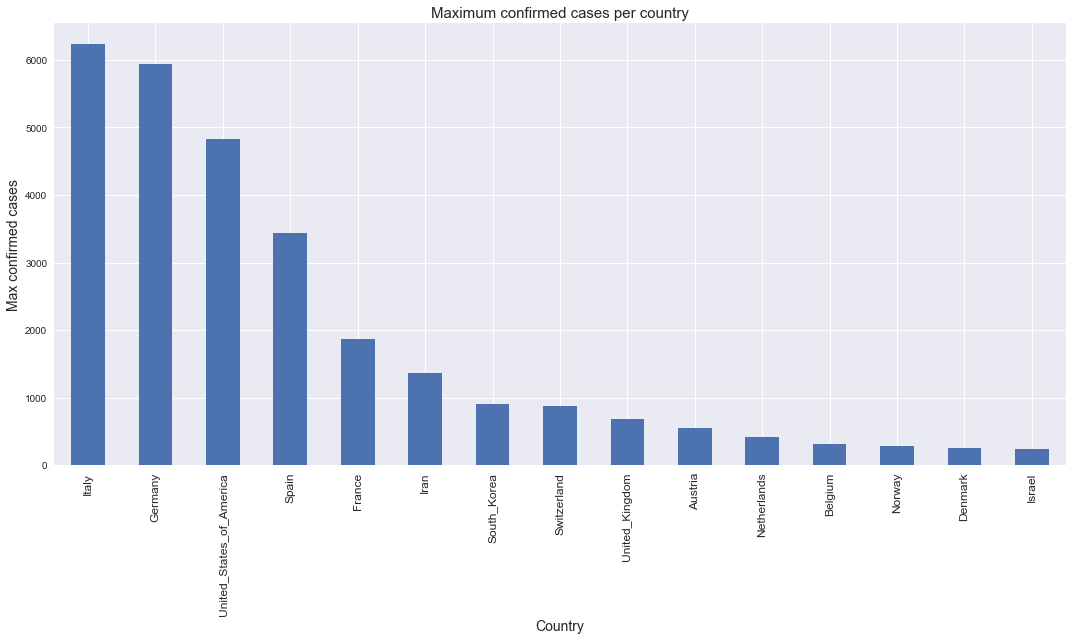

In [6]:
df.groupby('Country')['Cases'].max().sort_values(ascending=False).head(15).plot(kind='bar', figsize=(15,9))
plt.xticks(size=12)
plt.ylabel('Max confirmed cases', size=14)
plt.xlabel('Country', size=14)
plt.title('Maximum confirmed cases per country', size=15)
plt.tight_layout()
plt.savefig('../plots/plt1.png', dpi=100)
plt.show()

### countries with highest total confirmed cases

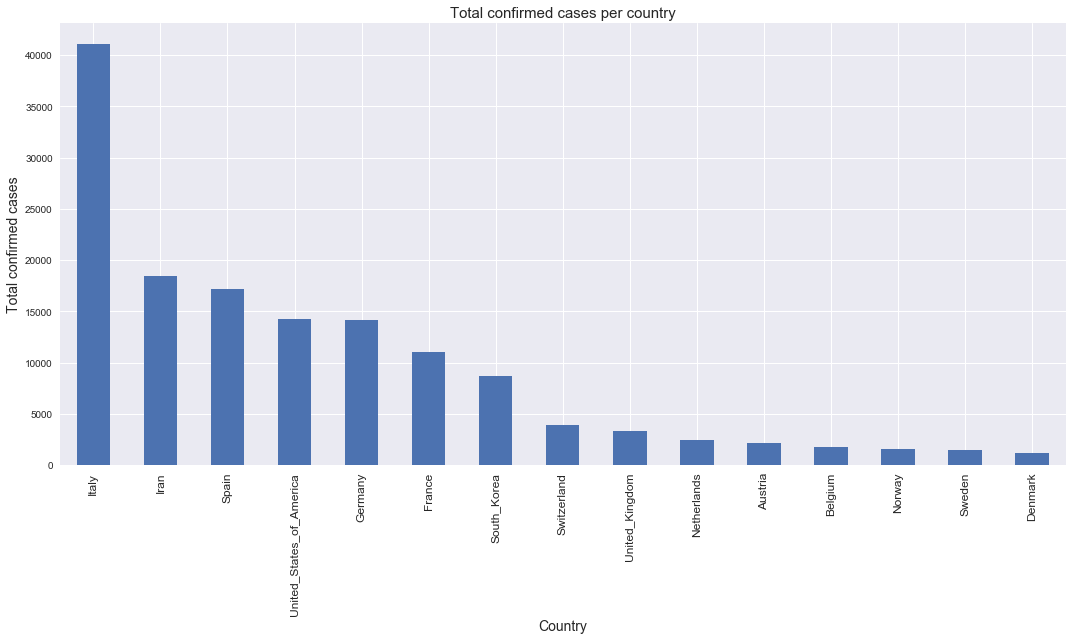

In [7]:
df.groupby('Country')['Cases'].sum().sort_values(ascending=False).head(15).plot(kind='bar', figsize=(15,9))
plt.xticks(size=12)
plt.ylabel('Total confirmed cases', size=14)
plt.xlabel('Country', size=14)
plt.title('Total confirmed cases per country', size=15)
plt.tight_layout()
plt.savefig('../plots/plt2.png', dpi=100)
plt.show()

### top 15 total deaths per country

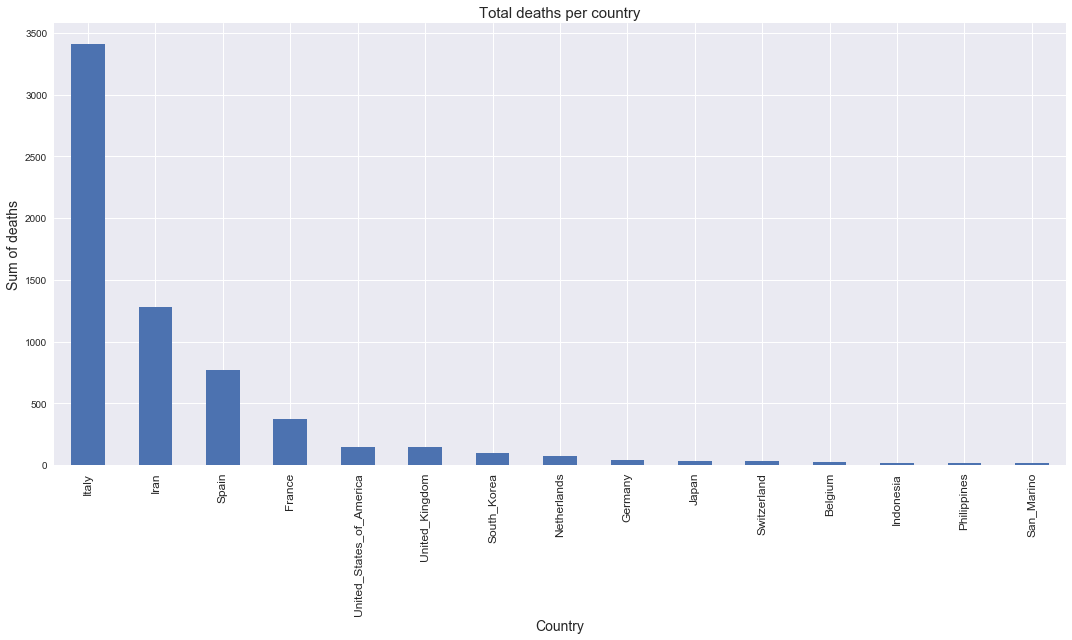

In [8]:
df.groupby('Country')['Deaths'].sum().sort_values(ascending=False).head(15).plot(kind='bar', figsize=(15,9))
plt.xticks(size=12)
plt.ylabel('Sum of deaths', size=14)
plt.xlabel('Country', size=14)
plt.title('Total deaths per country', size=15)
plt.tight_layout()
plt.savefig('../plots/plt3.png')
plt.show()

### cumulative sum of confirmed cases over time

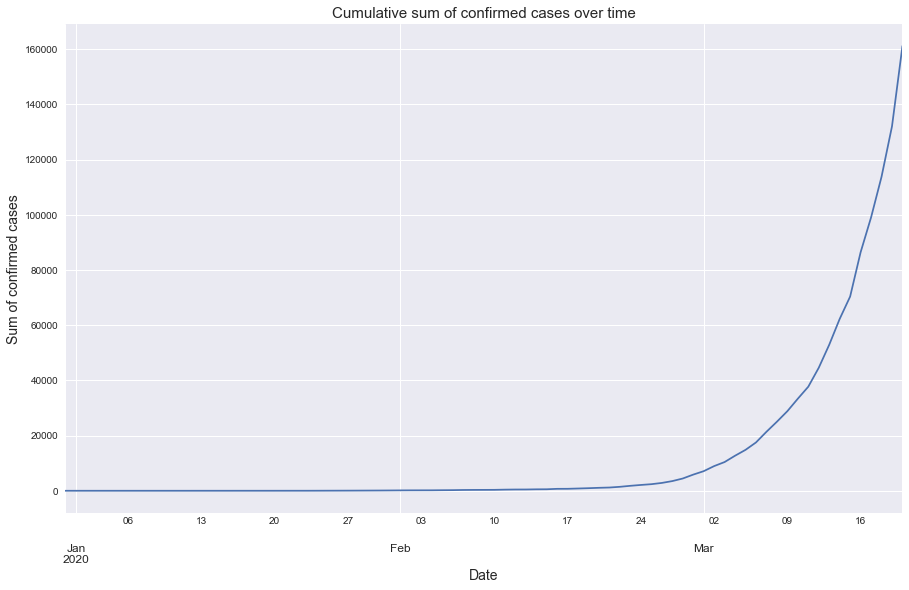

In [9]:
cases_cumsum = df.groupby('Date')['Cases'].sum().cumsum()
cases_cumsum.plot(figsize=(15,9))
plt.xticks(size=12)
plt.ylabel('Sum of confirmed cases', size=14)
plt.xlabel('Date', size=14)
plt.title('Cumulative sum of confirmed cases over time', size=15)
plt.savefig('../plots/plt4.png')
plt.show()

### The log of cumulative sum to check if growth is actually exponential

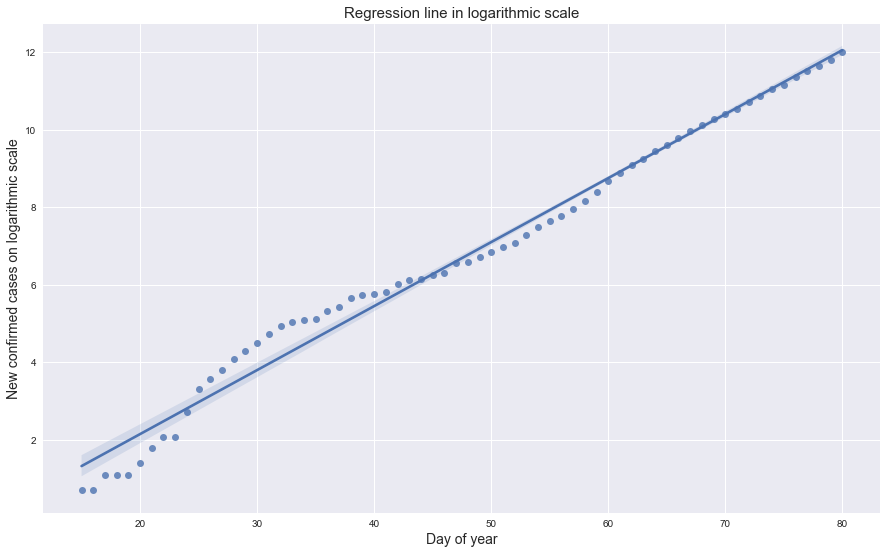

In [10]:
log_cumsum = np.log(cases_cumsum[cases_cumsum.gt(1)]).to_frame().reset_index()
log_cumsum['Date'] = log_cumsum['Date'].dt.dayofyear

plt.figure(figsize=(15,9))
plt.title("Regression line in logarithmic scale", size=15)
sns.regplot(x='Date', y='Cases', data=log_cumsum)
plt.xlabel('Day of year', size=14)
plt.ylabel('New confirmed cases on logarithmic scale', size=14)
plt.savefig('../plots/plt5.png')
plt.show()

### fit a regression line through the log of confirmed cases, this way we can check R^2 

In [11]:
X = log_cumsum['Date']
y = log_cumsum['Cases']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Cases   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          1.030e+04
Date:                Fri, 20 Mar 2020   Prob (F-statistic):                    2.60e-73
Time:                        17:38:38   Log-Likelihood:                         -58.377
No. Observations:                  66   AIC:                                      118.8
Df Residuals:                      65   BIC:                                      120.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Date           0.1441      0.001    101.464      0.000       0.141       0.147
==============================================================================
Omnibus:                       17.705   Durbin-Watson:                   0.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.261
Skew:                          -1.328   Prob(JB):                     2.42e-05
Kurtosis:                       3.824   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### growth proportion per day, > 1 means we are still in an exponential growth

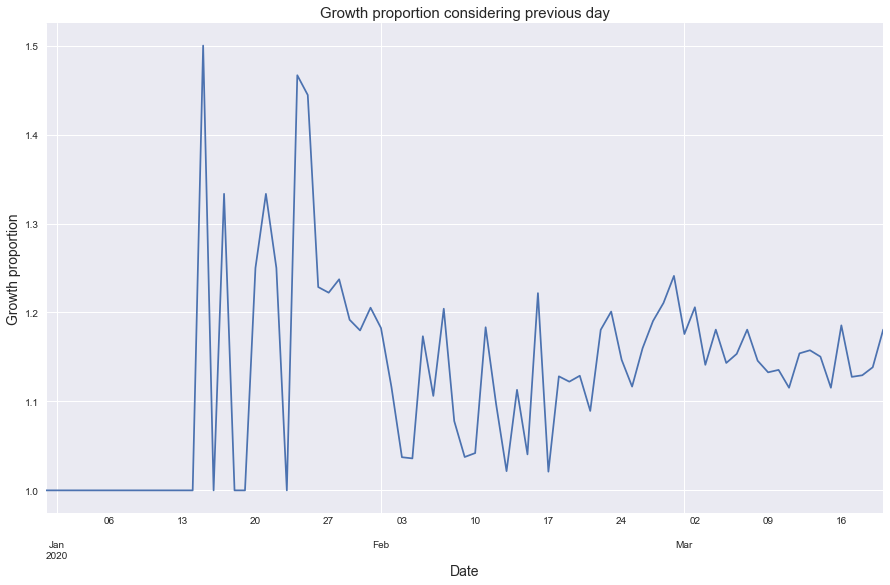

In [12]:
cases_cumsum = cases_cumsum.replace(0, 1)
cases_cumsum.diff().div(cases_cumsum).add(1).fillna(1).plot(figsize=(15,9))

plt.title('Growth proportion considering previous day', size=15)
plt.xlabel('Date', size=14)
plt.ylabel('Growth proportion', size=14)
plt.savefig('../plots/plt6.png')
plt.show()

### time series analysis

In [13]:
from itertools import product

p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]

In [14]:
y = cases_cumsum
y.index = pd.DatetimeIndex(y.index.values,
                           freq=y.index.inferred_freq)

results_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            results_list.append((param, param_seasonal, results.aic))
            print(f'ARIMA{param}x{param_seasonal}12 - AIC:{results.aic}')
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1898.6696675778885
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1613.919446275722
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1604.2223547407673
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1328.7620805611716
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1315.7289531408355
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1294.7222403193284
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1114.4794829471543
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1091.9879404087542
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1952.348404330068
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1560.5278953694738
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1524.158585025262
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1251.1351487898742
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1244.2827630546929


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1209.8214770597517
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1052.7502577611492


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1022.8537431659353
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1580.2818093484016
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1347.4143792922532
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1328.973613587869
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1103.846091930159
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1168.1898959824566
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1153.962679116284
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:973.2417603277204
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:958.85186391019
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1641.9000153426632
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1378.5027289159389


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1313.409811115075
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1123.3053751961338
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1167.0564953480257
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1136.7651218779345
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1082.480240256984
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:942.2680919435041
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1334.0366373461702
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1148.3930156010545
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1148.0966208261232
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:961.6930332542654
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1147.1543816092098
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1174.7217848190826
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:958.6741836715823


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:960.5812702544126
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1298.8840528680819
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1118.4593387808832
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1120.3705704273414
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:931.5642837219743
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1125.296172689747


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1110.5511981449597
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:944.6440905475488
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:930.0842083452949
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1371.0439427774563
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1175.8679499958323
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1173.1469507778872


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:976.8394057888514
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1150.683292503023
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1152.5040741314147
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:955.7436607668644
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:957.7178260820334
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1313.258003127081
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1122.6473825142034
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1124.972748557741
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:931.2817413921932
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:1157.162189379448


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1139.021512735596
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:956.7138418432462
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:942.4033719048408


In [15]:
min_aic = min([aic for x, y, aic in results_list if aic > 0])
for param, p_seasonal, aic in results_list:
    if aic == min_aic:
        p, p_s, a = param, p_seasonal, aic

print(p, p_s, a)

(1, 0, 1) (1, 1, 1, 12) 930.0842083452949


In [16]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=p,
                                seasonal_order=p_s,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1747      0.002    779.430      0.000       1.172       1.178
ma.L1         -0.7483      0.062    -12.074      0.000      -0.870      -0.627
ar.S.L12      -1.4970      0.830     -1.804      0.071      -3.124       0.130
ma.S.L12      -0.2882      0.958     -0.301      0.764      -2.167       1.590
sigma2       1.03e+06   1.01e-05   1.02e+11      0.000    1.03e+06    1.03e+06


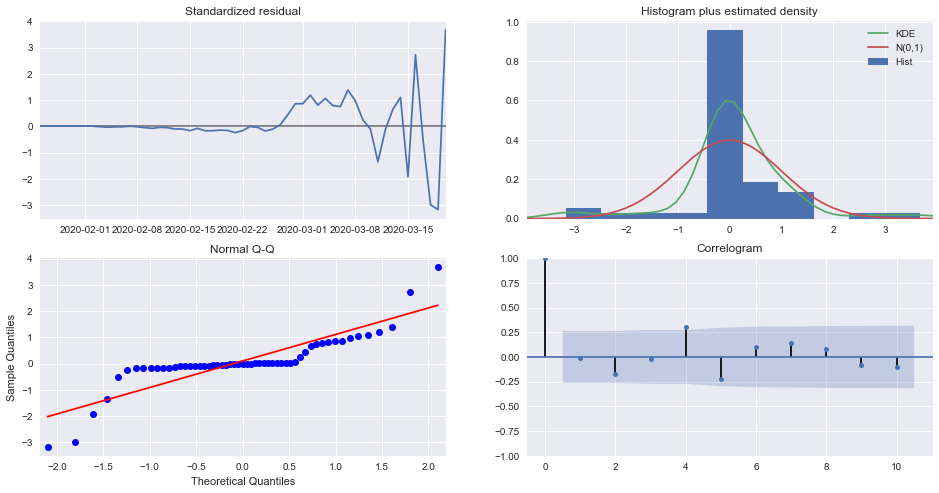

In [17]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('../plots/plt7.png')
plt.show()

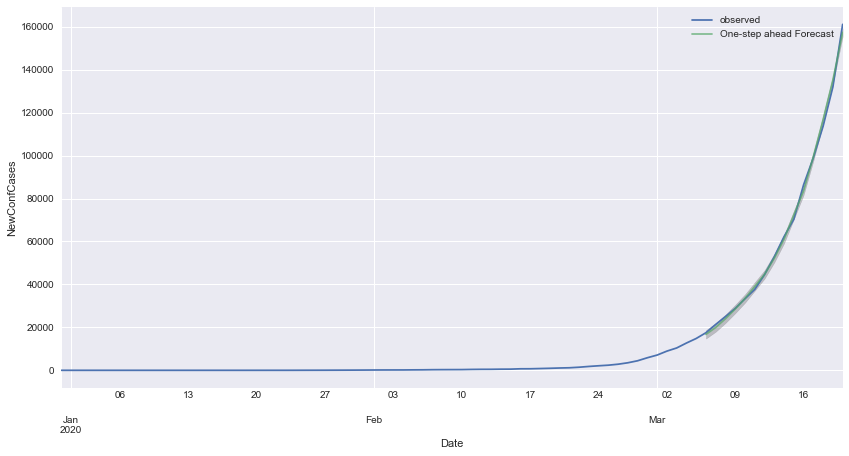

In [18]:
pred = results.get_prediction(start=(y.index.max() - pd.Timedelta(days=14)), dynamic=False)
pred_ci = pred.conf_int()
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('NewConfCases')
plt.legend()
plt.savefig('../plots/plt8.png')
plt.show()

In [19]:
y_forecasted = pred.predicted_mean
y_truth = y[(y.index.max() - pd.Timedelta(days=14)):]
mse = ((y_forecasted - y_truth) ** 2).mean()
print(f'The Mean Squared Error of our forecasts is {round(mse, 2)}')

The Mean Squared Error of our forecasts is 3489144.18


In [20]:
print(f'The Root Mean Squared Error of our forecasts is {round(np.sqrt(mse), 2)}')

The Root Mean Squared Error of our forecasts is 1867.93


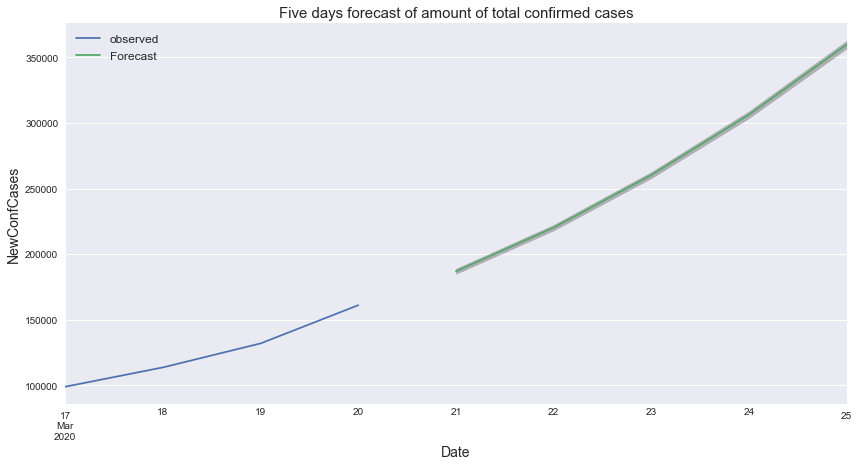

In [21]:
pred_uc = results.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()
ax = y[(y.index.max() - pd.Timedelta(days=3)):].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('NewConfCases', size=14)
plt.legend(fontsize=12)
plt.title('Five days forecast of amount of total confirmed cases', size=15)
plt.savefig('../plots/plt9.png')
plt.show()

# Netherlands

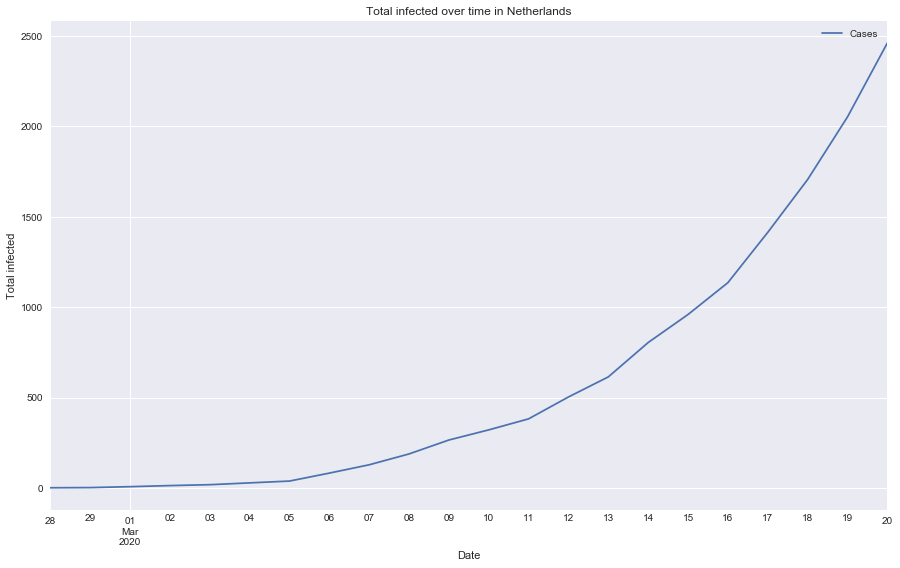

In [22]:
df.query('Country == "Netherlands" & Cases > 0').loc[:, ['Date', 'Cases']].set_index('Date').sort_index().cumsum().plot(figsize=(15,9))
plt.ylabel('Total infected')
plt.title('Total infected over time in Netherlands')
plt.savefig('../plots/NL1.png')
plt.show()

In [23]:
df.query('Country == "Netherlands" & Cases > 0')

,Date,Day,Month,Year,Cases,Deaths,Country,GeoId
3726,2020-03-20,20,3,2020,409,18,Netherlands,NL
3727,2020-03-19,19,3,2020,346,34,Netherlands,NL
3728,2020-03-18,18,3,2020,292,0,Netherlands,NL
3729,2020-03-17,17,3,2020,278,4,Netherlands,NL
3730,2020-03-16,16,3,2020,176,8,Netherlands,NL
3731,2020-03-15,15,3,2020,155,7,Netherlands,NL
3732,2020-03-14,14,3,2020,190,0,Netherlands,NL
3733,2020-03-13,13,3,2020,111,0,Netherlands,NL
3734,2020-03-12,12,3,2020,121,1,Netherlands,NL
3735,2020-03-11,11,3,2020,61,1,Netherlands,NL


### Amount of confirmed cases per city

In [24]:
per_city = pd.read_csv(os.path.join('..', 'data', 'cases_per_municipality.csv'), sep=';')
per_city['Aantal per 100.000 inwoners'] = per_city['Aantal per 100.000 inwoners'].str.replace(',', '.').astype(float)
per_city.head()

,Category,Aantal per 100.000 inwoners,Aantal
0,'s-Gravenhage,6.7,36
1,'s-Hertogenbosch,24.6,38
2,Aa en Hunze,0.0,0
3,Aalsmeer,15.8,5
4,Aalten,3.7,1


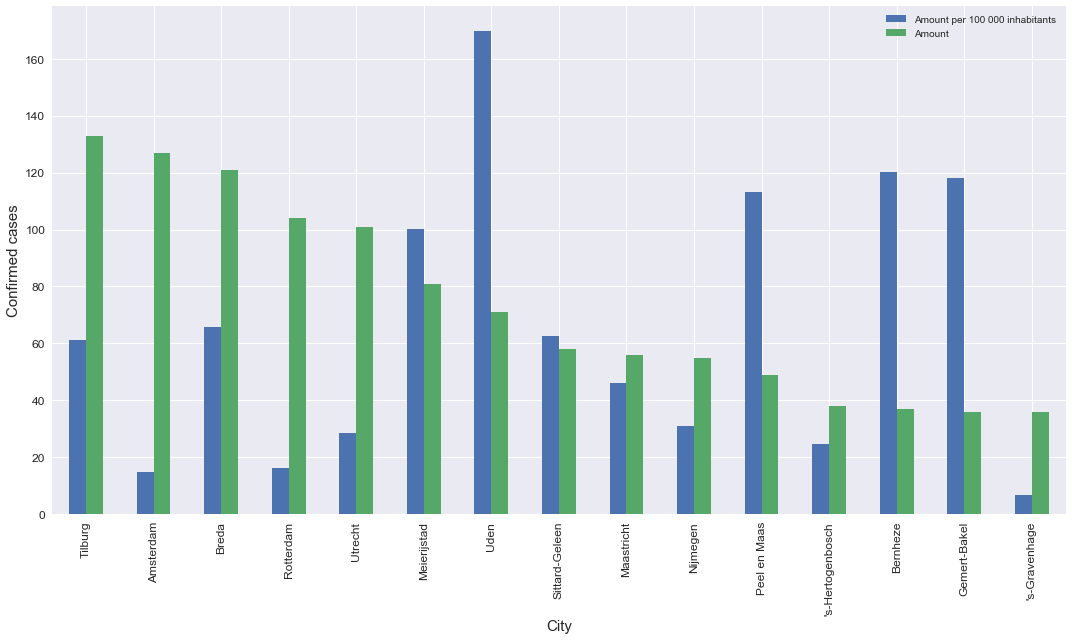

In [25]:
per_city.sort_values('Aantal', ascending=False).head(15).plot(kind='bar', figsize=(15,9), x='Category')
plt.xlabel('City', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel('Confirmed cases', size=15)
plt.legend(['Amount per 100 000 inhabitants', 'Amount'])
plt.tight_layout()
plt.savefig('../plots/NL2.png')
plt.show()

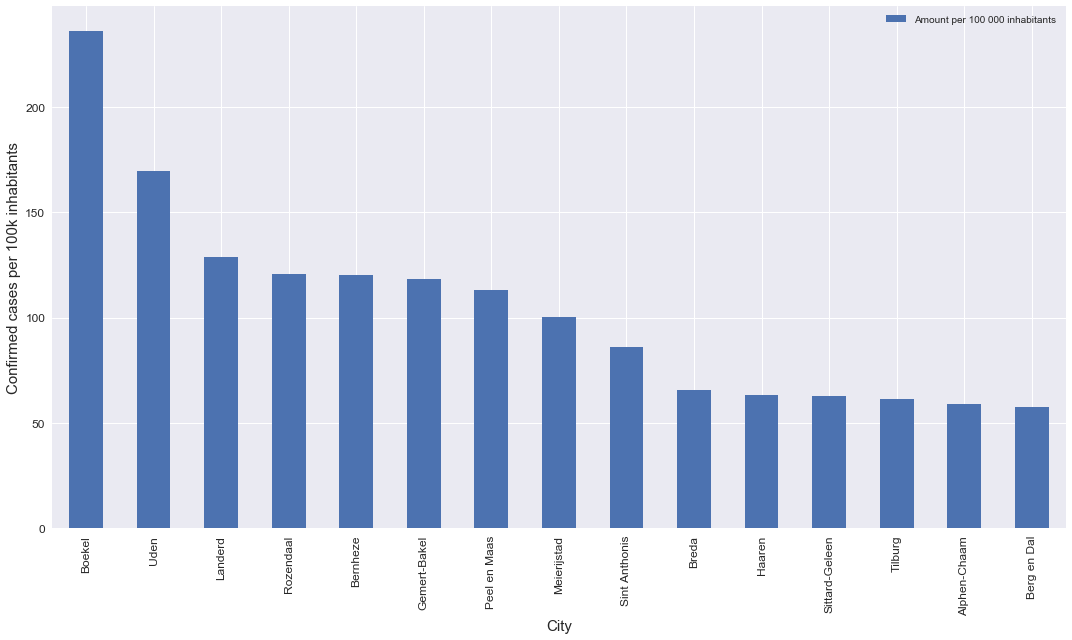

In [26]:
per_city.sort_values('Aantal per 100.000 inwoners', ascending=False).head(15).plot(kind='bar', figsize=(15,9), x='Category', y='Aantal per 100.000 inwoners')
plt.xlabel('City', size=15)
plt.xticks(size=12)
plt.ylabel('Confirmed cases per 100k inhabitants', size=15)
plt.yticks(size=12)
plt.legend(['Amount per 100 000 inhabitants', 'Amount'])
plt.tight_layout()
plt.savefig('../plots/NL3.png')
plt.show()

# China

In [27]:
china = china.set_index('Date').sort_index()
china.sort_index(ascending=False)

,Day,Month,Year,Cases,Deaths,Country,GeoId
Date,,,,,,,
2020-03-20,20,3,2020,99,4,China,CN
2020-03-19,19,3,2020,75,8,China,CN
2020-03-18,18,3,2020,33,16,China,CN
2020-03-17,17,3,2020,110,9,China,CN
2020-03-16,16,3,2020,25,14,China,CN
...,...,...,...,...,...,...,...
2020-01-04,4,1,2020,0,0,China,CN
2020-01-03,3,1,2020,17,0,China,CN
2020-01-02,2,1,2020,0,0,China,CN


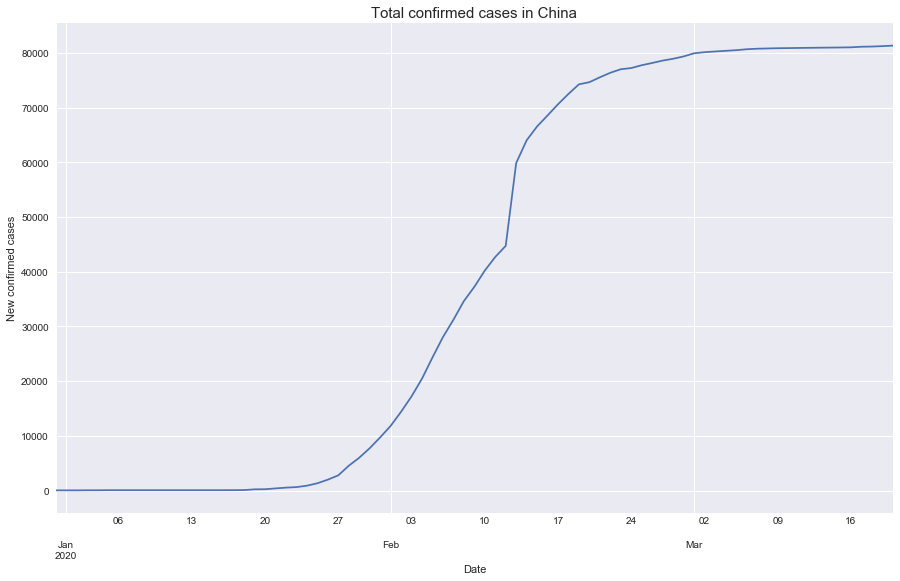

In [28]:
china['Cases'].cumsum().plot(figsize=(15,9))
plt.ylabel('New confirmed cases')
plt.title('Total confirmed cases in China', size=15)
plt.savefig('../plots/china1.png')
plt.show()

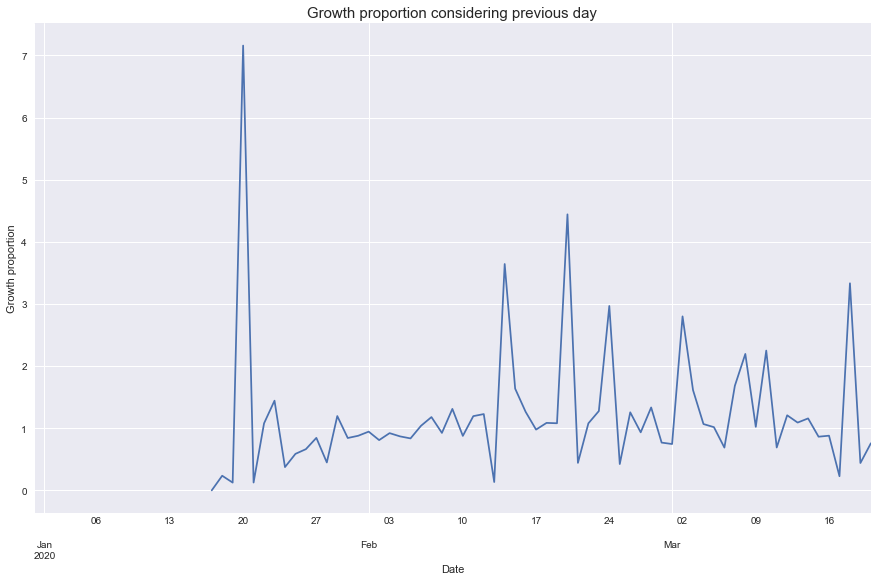

In [29]:
china['Cases'].shift().div(china['Cases']).plot(figsize=(15,9))
plt.ylabel('Growth proportion')
plt.title('Growth proportion considering previous day', size=15)
plt.savefig('../plots/china1.png')
plt.show()

---